# 1P - Model Evaluation

In [1]:
from os import path

import numpy as np
import h5py
from tqdm import tqdm
from keras.models import load_model

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from rnn_tauid.common.mpl_setup import mpl_setup
mpl_setup()

Using Theano backend.


Input files:

In [2]:
# Sample paths
sig_jet_fname = "/lustre/user/cdeutsch/rnn-samples-v4/sig1P_jet.h5"
bkg_jet_fname = "/lustre/user/cdeutsch/rnn-samples-v4/bkg1P_jet_shuffle.h5"
sig_track_fname = "/lustre/user/cdeutsch/rnn-samples-v4/sig1P_track.h5"
bkg_track_fname = "/lustre/user/cdeutsch/rnn-samples-v4/bkg1P_track_shuffle.h5"

# Model files
model_fname = "/lustre/user/cdeutsch/rnn-feature-samples-v4/saved_models/track_valloss_0_2221/track_model.h5"
preprocessing_fname = "/lustre/user/cdeutsch/rnn-feature-samples-v4/saved_models/track_valloss_0_2221/track_preproc.h5"

# Plot output prefix
plot_prefix = "/lustre/user/cdeutsch/rnn-feature-samples-v4/track_plots/"

In [3]:
# Tau-level datasets
sigf_jet = h5py.File(sig_jet_fname, "r")
bkgf_jet = h5py.File(bkg_jet_fname, "r")
sig_jet = sigf_jet["jet"]
bkg_jet = bkgf_jet["jet"]

# Track-level datasets
sigf_track = h5py.File(sig_track_fname, "r")
bkgf_track = h5py.File(bkg_track_fname, "r")
sig_track = sigf_track["track"]
bkg_track = bkgf_track["track"]

In [4]:
with h5py.File(preprocessing_fname, "r") as f:
    invars = np.char.decode(f["variables"][...]).tolist()
    offset = {v: f[v + "/offset"][...] for v in invars}
    scale = {v: f[v + "/scale"][...] for v in invars}

n_vars = len(invars)
n_tracks = len(offset[invars[0]])

In [5]:
model = load_model(model_fname)
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 10, 10)        0                                            
____________________________________________________________________________________________________
masking_1 (Masking)              (None, 10, 10)        0           input_1[0][0]                    
____________________________________________________________________________________________________
timedistributed_1 (TimeDistribut (None, 10, 32)        352         masking_1[0][0]                  
____________________________________________________________________________________________________
lstm_1 (LSTM)                    (None, 32)            8320        timedistributed_1[0][0]          
___________________________________________________________________________________________

In [6]:
# Get the testing slice
total_frac = 0.2
test_start = int(total_frac * min(len(sig_track), len(bkg_track)))
print("[{}:] for testing".format(test_start))

[1308853:] for testing


In [7]:
sig_pred = np.zeros(len(sig_track) - test_start, dtype=np.float32)
bkg_pred = np.zeros(len(bkg_track) - test_start, dtype=np.float32)

In [8]:
buf_size = 512 * 1024**2 // (4 * n_tracks * n_vars)  # 512 MB buffer
buf = np.empty((buf_size, n_tracks, n_vars), dtype=np.float32)

In [9]:
for track, jet, pred in [(sig_track, sig_jet, sig_pred), (bkg_track, bkg_jet, bkg_pred)]:
    chunks = [(start, min(start + buf_size, len(track))) for start in range(test_start, len(track), buf_size)]
    pred_idx = 0

    for start, stop in tqdm(chunks):
        # Fill buffer (skip first because ptfrac)
        n_write = stop - start
        for i, var in enumerate(invars[1:], 1):
            # Read variable into buffer
            buf_view = buf[:n_write, :, i]
            buf_view[...] = track[start:stop, :n_tracks, var]

            # Apply preprocessing
            buf_view -= offset[var]
            buf_view /= scale[var]

            # Remove nan
            buf_view[np.isnan(buf_view)] = 0

        # Read ptfrac (TODO: make more convenient -> rnn_tauid.common.variables)
        pt_track = track[start:stop, :n_tracks, "TauTracks.pt"]
        pt_jet = jet[start:stop, "TauJets.ptJetSeed"][:, np.newaxis]

        buf_view = buf[:n_write, :, 0]
        buf_view[...] = np.clip(pt_track / pt_jet, 0.0, 1.5)
        buf_view -= offset["TauTracks.ptfrac"]
        buf_view /= scale["TauTracks.ptfrac"]
        buf_view[np.isnan(buf_view)] = 0

        # Predict
        pred[pred_idx:pred_idx + n_write] = model.predict(buf[:n_write], batch_size=512).ravel()
        pred_idx += n_write

    if not pred_idx == len(pred):
        import pdb; pdb.set_trace()
    assert pred_idx == len(pred)

del buf

100%|██████████| 4/4 [20:00<00:00, 306.94s/it]


## Evaluation plots

In [10]:
from sklearn.metrics import roc_auc_score
from scipy.interpolate import interp1d

In [11]:
from rnn_tauid.evaluation.misc import roc_curve, binned_efficiency, bin_center, bin_width
from rnn_tauid.evaluation.flattener import Flattener
import rnn_tauid.common.binnings as binnings

## RNN track score distribution:

/lustre/user/cdeutsch/miniconda2/envs/ML/lib/python2.7/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


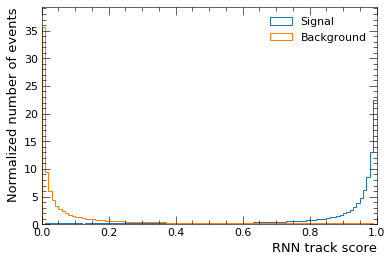

In [12]:
histopt = dict(bins=100, range=(0, 1), normed=True, histtype="step")
plt.hist(sig_pred, label="Signal", **histopt)
plt.hist(bkg_pred, label="Background", **histopt)
plt.xlabel("RNN track score", ha="right", x=1.0)
plt.ylabel("Normalized number of events", ha="right", y=1.0)
lo, hi = plt.ylim()
plt.ylim((lo, 1.1 * hi))
plt.legend()

plt.savefig(path.join(plot_prefix, "track_score_1p.pdf"))

## R21 $\tau$-ID:

In [13]:
sig_ntuple_fname = "/lustre/user/cdeutsch/Data/R21-Training/sig1P_test_deco.h5"
bkg_ntuple_fname = "/lustre/user/cdeutsch/Data/R21-Training/bkg1P_test_deco.h5"

with h5py.File(sig_ntuple_fname, "r") as s, h5py.File(bkg_ntuple_fname, "r") as b:
    r21 = {
        "y_score": np.concatenate([
            s["CollectionTree"]["vars2016_pt_gamma_1p_isofix"],
            b["CollectionTree"]["vars2016_pt_gamma_1p_isofix"]
        ]),
        "y_true": np.concatenate([
            np.ones(len(s["CollectionTree"])),
            np.zeros(len(b["CollectionTree"]))
        ]),
        "weight": np.concatenate([
            s["CollectionTree"]["weight"],
            b["CollectionTree"]["weight"]
        ]),
        "pt": np.concatenate([
            s["CollectionTree"]["TauJets.pt"],
            b["CollectionTree"]["TauJets.pt"]
        ]),
        "mu": np.concatenate([
            s["CollectionTree"]["TauJets.mu"],
            b["CollectionTree"]["TauJets.mu"]
        ]),
        "nVtxPU": np.concatenate([
            s["CollectionTree"]["TauJets.nVtxPU"],
            b["CollectionTree"]["TauJets.nVtxPU"]
        ])
    }

r21["is_sig"] = r21["y_true"] == 1

## ROC-Curve

In [14]:
y_true = np.concatenate([np.ones_like(sig_pred), np.zeros_like(bkg_pred)])
y_score = np.concatenate([sig_pred, bkg_pred])

In [15]:
auc = roc_auc_score(y_true, y_score)
r21_auc = roc_auc_score(r21["y_true"], r21["y_score"])

eff, rej = roc_curve(y_true, y_score)
r21_eff, r21_rej = roc_curve(r21["y_true"], r21["y_score"])

In [16]:
roc = interp1d(eff, rej, bounds_error=False, copy=False)
r21_roc = interp1d(r21_eff, r21_rej, bounds_error=False, copy=False)

ratio_eff = np.linspace(0.0, 1.0, 100)
ratio_rej = roc(ratio_eff) / r21_roc(ratio_eff)

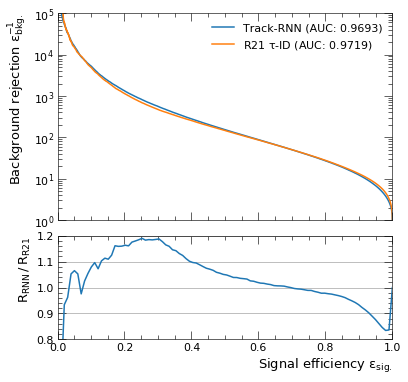

In [17]:
fig = plt.figure(figsize=(6, 6))
gs = mpl.gridspec.GridSpec(2, 1, height_ratios=[2, 1], hspace=0.1)

# ROC-Curves
ax0 = plt.subplot(gs[0])
ax0.plot(eff, rej, label="Track-RNN (AUC: {:.4})".format(auc))
ax0.plot(r21_eff, r21_rej, label=r"R21 $\tau$-ID (AUC: {:.4})".format(r21_auc))
ax0.set_yscale("log")
ax0.set_xlim((0.0, 1.0))
ax0.set_ylim((1e0, 1e5))
ax0.set_ylabel(r"Background rejection $\varepsilon_\mathrm{bkg.}^{-1}$", ha="right", y=1.0)
ax0.tick_params(labelbottom="off")
ax0.legend()

# Ratio
ax1 = plt.subplot(gs[1], sharex=ax0)
ax1.plot(ratio_eff, ratio_rej)
ax1.set_ylim((0.8, 1.2))
ax1.set_xlabel(r"Signal efficiency $\varepsilon_\mathrm{sig.}$", ha="right", x=1.0)
ax1.set_ylabel(r"$R_\mathrm{RNN} \, / \, R_\mathrm{R21}$", ha="right", y=1.0)
ax1.grid(axis="y")

fig.savefig(path.join(plot_prefix, "track_roc_1p.pdf"))

## $p_\mathrm{T}$ / $\mu$-flattening and working point calculation

In [18]:
wp_eff = 0.6

### R21:

In [19]:
r21_flat = Flattener(binnings.pt_flat, binnings.mu_flat, wp_eff)

r21_passes_thr = r21_flat.fit(r21["pt"][r21["is_sig"]],
                              r21["mu"][r21["is_sig"]],
                              r21["y_score"][r21["is_sig"]])

assert np.isclose(np.count_nonzero(r21_passes_thr) / float(len(r21_passes_thr)), wp_eff, atol=0, rtol=1e-2)

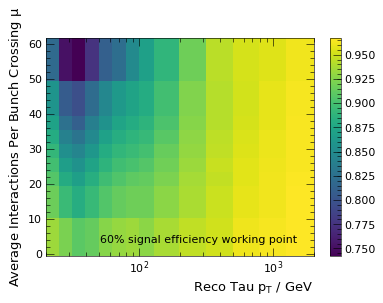

In [20]:
X, Y = np.meshgrid(r21_flat.x_bins, r21_flat.y_bins)
plt.pcolormesh(X / 1000.0, Y, r21_flat.cutmap.T)
plt.xscale("log")
plt.xlabel(r"Reco Tau $p_\mathrm{T}$ / GeV", ha="right", x=1.0)
plt.ylabel(r"Average Interactions Per Bunch Crossing $\mu$")
plt.annotate("{:.0%} signal efficiency working point".format(wp_eff),
             xy=(0.94, 0.06), xycoords="axes fraction",
             horizontalalignment="right")
plt.colorbar()
plt.savefig(path.join(plot_prefix, "r21_wp_cutmap_1p.pdf"))

### Track-RNN:

In [21]:
flat = Flattener(binnings.pt_flat, binnings.mu_flat, wp_eff)

passes_thr = flat.fit(sig_jet["TauJets.pt"][test_start:],
                      sig_jet["TauJets.mu"][test_start:],
                      sig_pred)

assert np.isclose(np.count_nonzero(passes_thr) / float(len(passes_thr)), wp_eff, atol=0, rtol=1e-2)

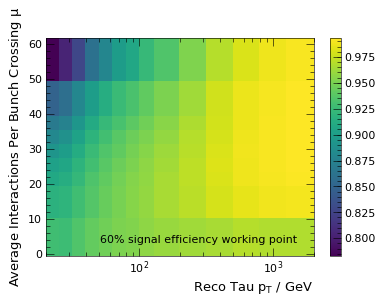

In [22]:
X, Y = np.meshgrid(flat.x_bins, flat.y_bins)
plt.pcolormesh(X / 1000.0, Y, flat.cutmap.T)
plt.xscale("log")
plt.xlabel(r"Reco Tau $p_\mathrm{T}$ / GeV", ha="right", x=1.0)
plt.ylabel(r"Average Interactions Per Bunch Crossing $\mu$")
plt.annotate("{:.0%} signal efficiency working point".format(wp_eff),
             xy=(0.94, 0.06), xycoords="axes fraction",
             horizontalalignment="right")
plt.colorbar()
plt.savefig(path.join(plot_prefix, "track_wp_cutmap_1p.pdf"))

### Signal efficiency vs. $p_\mathrm{T}$

In [23]:
r21_sig_pt = r21["pt"][r21["is_sig"]]
sig_pt = sig_jet["TauJets.pt"][test_start:]

bins = np.percentile(r21_sig_pt, np.linspace(0.0, 100.0, 30))
bin_midpoint = bin_center(bins)
bin_half_width = bin_width(bins) / 2.0

r21_eff_pt = binned_efficiency(r21_sig_pt, r21_passes_thr, bins=bins)
eff_pt = binned_efficiency(sig_pt, passes_thr, bins=bins)

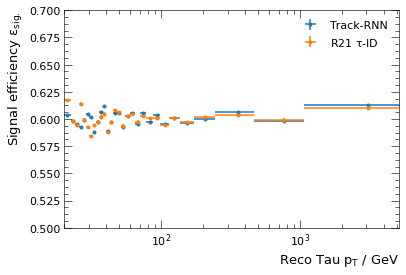

In [24]:
plt.errorbar(bin_midpoint / 1000.0, eff_pt.mean,
             xerr=bin_half_width / 1000.0, yerr=eff_pt.std,
             fmt=".", label="Track-RNN")
plt.errorbar(bin_midpoint / 1000.0, r21_eff_pt.mean,
             xerr=bin_half_width / 1000.0, yerr=r21_eff_pt.std,
             fmt=".", label="R21 $\\tau$-ID")
plt.ylim((0.50, 0.70))
plt.xscale("log")
plt.xlabel("Reco Tau $p_\\mathrm{T}$ / GeV", ha="right", x=1.0)
plt.ylabel("Signal efficiency $\\varepsilon_\\mathrm{sig.}$", ha="right", y=1.0)
plt.legend()
plt.savefig(path.join(plot_prefix, "track_wp_eff_1p.pdf"))

### Signal efficiency vs. $\mu$

In [25]:
r21_sig_nVtx = r21["nVtxPU"][r21["is_sig"]]
sig_nVtx = sig_jet["TauJets.nVtxPU"][test_start:]

bins = binnings.nVtx
bin_midpoint = bin_center(bins)
bin_half_width = bin_width(bins) / 2.0

r21_eff_nVtx = binned_efficiency(r21_sig_nVtx, r21_passes_thr, bins=bins)
eff_nVtx = binned_efficiency(sig_nVtx, passes_thr, bins=bins)

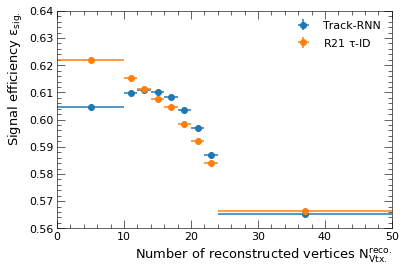

In [26]:
plt.errorbar(bin_midpoint, eff_nVtx.mean,
             xerr=bin_half_width, yerr=eff_nVtx.std,
             fmt="o", label="Track-RNN")
plt.errorbar(bin_midpoint, r21_eff_nVtx.mean,
             xerr=bin_half_width, yerr=r21_eff_nVtx.std,
             fmt="o", label="R21 $\\tau$-ID")
plt.ylim((0.56, 0.64))
plt.xlabel("Number of reconstructed vertices $N_\\mathrm{Vtx.}^\\mathrm{reco.}$", ha="right", x=1.0)
plt.ylabel("Signal efficiency $\\varepsilon_\\mathrm{sig.}$", ha="right", y=1.0)
plt.legend()
plt.savefig(path.join(plot_prefix, "r21_wp_eff_v_nVtx_1p.pdf"))

## Background efficiency / rejection

### Low-$p_\mathrm{T}$

In [27]:
r21_bkg_pt = r21["pt"][~r21["is_sig"]]
bkg_pt = bkg_jet["TauJets.pt"][test_start:]

r21_bkg_mu = r21["mu"][~r21["is_sig"]]
bkg_mu = bkg_jet["TauJets.mu"][test_start:]

r21_bkg_pass_thr = r21_flat.passes_thr(r21_bkg_pt, r21_bkg_mu, r21["y_score"][~r21["is_sig"]])
bkg_pass_thr = flat.passes_thr(bkg_pt, bkg_mu, bkg_pred)

In [28]:
bins = 10 ** np.linspace(np.log10(20000), np.log10(300000), 11)
bin_midpoint = bin_center(bins)
bin_half_width = bin_width(bins) / 2.0

# Background efficiency
r21_bkg_eff_pt = binned_efficiency(r21_bkg_pt, r21_bkg_pass_thr, bins=bins)
bkg_eff_pt = binned_efficiency(bkg_pt, bkg_pass_thr, bins=bins)

# Background rejection
r21_rej_pt = 1.0 / r21_bkg_eff_pt.mean
rej_pt = 1.0 / bkg_eff_pt.mean

d_r21_rej_pt = r21_bkg_eff_pt.std / r21_bkg_eff_pt.mean ** 2
d_rej_pt = bkg_eff_pt.std / bkg_eff_pt.mean ** 2

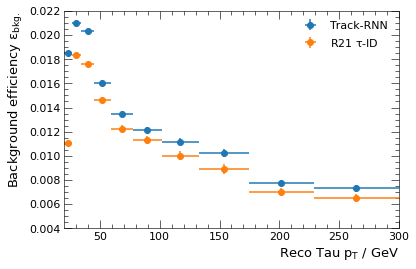

In [29]:
plt.errorbar(bin_midpoint / 1000.0, bkg_eff_pt.mean,
             xerr=bin_half_width / 1000.0, yerr=bkg_eff_pt.std,
             fmt="o", label="Track-RNN")
plt.errorbar(bin_midpoint / 1000.0, r21_bkg_eff_pt.mean,
             xerr=bin_half_width / 1000.0, yerr=r21_bkg_eff_pt.std,
             fmt="o", label="R21 $\\tau$-ID")
plt.xlim((20, 300))
plt.ylim((0.004, 0.022))
plt.xlabel("Reco Tau $p_\\mathrm{T}$ / GeV", ha="right", x=1.0)
plt.ylabel("Background efficiency $\\varepsilon_\\mathrm{bkg.}$", ha="right", y=1.0)
plt.legend()

plt.savefig(path.join(plot_prefix, "track_wp_bkgeff_1p.pdf"))

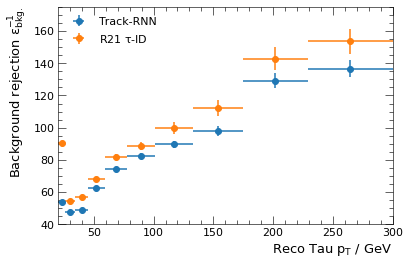

In [30]:
plt.errorbar(bin_midpoint / 1000.0, rej_pt,
             xerr=bin_half_width / 1000.0, yerr=d_rej_pt,
             fmt="o", label="Track-RNN")
plt.errorbar(bin_midpoint / 1000.0, r21_rej_pt,
             xerr=bin_half_width / 1000.0, yerr=d_r21_rej_pt,
             fmt="o", label="R21 $\\tau$-ID")
plt.xlim((20, 300))
plt.ylim((40, 175))
plt.xlabel("Reco Tau $p_\\mathrm{T}$ / GeV", ha="right", x=1.0)
plt.ylabel("Background rejection $\\varepsilon_\\mathrm{bkg.}^{-1}$", ha="right", y=1.0)
plt.legend()

plt.savefig(path.join(plot_prefix, "track_rejection_1p.pdf"))

### High-$p_\mathrm{T}$

In [31]:
bins = binnings.pt_flat
bin_midpoint = bin_center(bins)
bin_half_width = bin_width(bins) / 2.0

# Background efficiency
r21_bkg_eff_highpt = binned_efficiency(r21_bkg_pt, r21_bkg_pass_thr, bins=bins)
bkg_eff_highpt = binned_efficiency(bkg_pt, bkg_pass_thr, bins=bins)

# Background rejection
r21_rej_highpt = 1.0 / r21_bkg_eff_highpt.mean
rej_highpt = 1.0 / bkg_eff_highpt.mean

d_r21_rej_highpt = r21_bkg_eff_highpt.std / r21_bkg_eff_highpt.mean ** 2
d_rej_highpt = bkg_eff_highpt.std / bkg_eff_highpt.mean ** 2

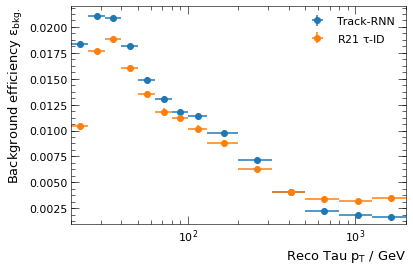

In [33]:
plt.errorbar(bin_midpoint / 1000.0, bkg_eff_highpt.mean,
             xerr=bin_half_width / 1000.0, yerr=bkg_eff_highpt.std,
             fmt="o", label="Track-RNN")
plt.errorbar(bin_midpoint / 1000.0, r21_bkg_eff_highpt.mean,
             xerr=bin_half_width / 1000.0, yerr=r21_bkg_eff_highpt.std,
             fmt="o", label="R21 $\\tau$-ID")
plt.xlim((20, 2000))
plt.ylim((0.001, 0.022))
plt.xscale("log")
plt.xlabel("Reco Tau $p_\\mathrm{T}$ / GeV", ha="right", x=1.0)
plt.ylabel("Background efficiency $\\varepsilon_\\mathrm{bkg.}$", ha="right", y=1.0)
plt.legend()

plt.savefig(path.join(plot_prefix, "track_wp_bkgeff_highpt_1p.pdf"))

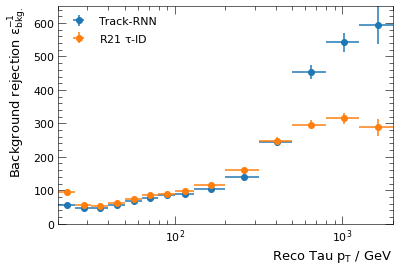

In [36]:
plt.errorbar(bin_midpoint / 1000.0, rej_highpt,
             xerr=bin_half_width / 1000.0, yerr=d_rej_highpt,
             fmt="o", label="Track-RNN")
plt.errorbar(bin_midpoint / 1000.0, r21_rej_highpt,
             xerr=bin_half_width / 1000.0, yerr=d_r21_rej_highpt,
             fmt="o", label="R21 $\\tau$-ID")
plt.xlim((20, 2000))
plt.ylim((0, 650))
plt.xscale("log")
plt.xlabel("Reco Tau $p_\\mathrm{T}$ / GeV", ha="right", x=1.0)
plt.ylabel("Background rejection $\\varepsilon_\\mathrm{bkg.}^{-1}$", ha="right", y=1.0)
plt.legend()

plt.savefig(path.join(plot_prefix, "track_rejection_highpt_1p.pdf"))

### Rejection vs. $\mu$

In [37]:
r21_bkg_mu = r21["mu"][~r21["is_sig"]]
bkg_mu = bkg_jet["TauJets.mu"][test_start:]

bins = binnings.mu_flat
bin_midpoint = bin_center(bins)
bin_half_width = bin_width(bins) / 2.0

r21_bkg_eff_mu = binned_efficiency(r21_bkg_mu, r21_bkg_pass_thr, bins=bins)
bkg_eff_mu = binned_efficiency(bkg_mu, bkg_pass_thr, bins=bins)

r21_rej_mu = 1.0 / r21_bkg_eff_mu.mean
rej_mu = 1.0 / bkg_eff_mu.mean

d_r21_rej_mu = r21_bkg_eff_mu.std / r21_bkg_eff_mu.mean ** 2
d_rej_mu = bkg_eff_mu.std / bkg_eff_mu.mean ** 2

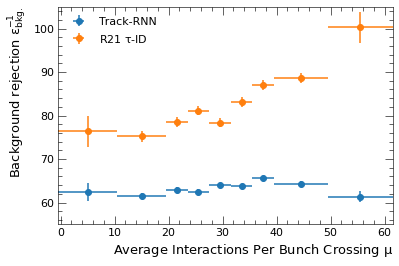

In [38]:
plt.errorbar(bin_midpoint, rej_mu,
             xerr=bin_half_width, yerr=d_rej_mu,
             fmt="o", label="Track-RNN")
plt.errorbar(bin_midpoint, r21_rej_mu,
             xerr=bin_half_width, yerr=d_r21_rej_mu,
             fmt="o", label="R21 $\\tau$-ID")
plt.ylim((55, 105))
plt.xlabel("Average Interactions Per Bunch Crossing $\\mu$", ha="right", x=1.0)
plt.ylabel("Background rejection $\\varepsilon_\\mathrm{bkg.}^{-1}$", ha="right", y=1.0)
plt.legend()

plt.savefig(path.join(plot_prefix, "track_rejection_mu_1p.pdf"))

### Rejection vs. nVtxPU

In [39]:
r21_bkg_nVtx = r21["nVtxPU"][~r21["is_sig"]]
bkg_nVtx = bkg_jet["TauJets.nVtxPU"][test_start:]

bins = binnings.nVtx
bin_midpoint = bin_center(bins)
bin_half_width = bin_width(bins) / 2.0

r21_bkg_eff_nVtx = binned_efficiency(r21_bkg_nVtx, r21_bkg_pass_thr, bins=bins)
bkg_eff_nVtx = binned_efficiency(bkg_nVtx, bkg_pass_thr, bins=bins)

r21_rej_nVtx = 1.0 / r21_bkg_eff_nVtx.mean
rej_nVtx = 1.0 / bkg_eff_nVtx.mean

d_r21_rej_nVtx = r21_bkg_eff_nVtx.std / r21_bkg_eff_nVtx.mean ** 2
d_rej_nVtx = bkg_eff_nVtx.std / bkg_eff_nVtx.mean ** 2

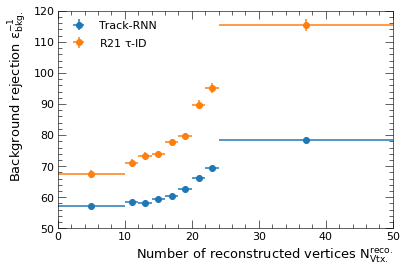

In [41]:
plt.errorbar(bin_midpoint, rej_nVtx, xerr=bin_half_width, yerr=d_rej_nVtx, fmt="o", label="Track-RNN")
plt.errorbar(bin_midpoint, r21_rej_nVtx, xerr=bin_half_width, yerr=d_r21_rej_nVtx, fmt="o", label="R21 $\\tau$-ID")
plt.ylim((50, 120))
plt.xlabel("Number of reconstructed vertices $N_\\mathrm{Vtx.}^\\mathrm{reco.}$", ha="right", x=1.0)
plt.ylabel("Background rejection $\\varepsilon_\\mathrm{bkg.}^{-1}$", ha="right", y=1.0)
plt.legend()

plt.savefig(path.join(plot_prefix, "track_rejection_nVtx_1p.pdf"))

In [42]:
sigf_jet.close()
bkgf_jet.close()
sigf_track.close()
bkgf_track.close()